In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import tf_py_environment
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import tensor_spec, from_spec
from tf_agents import trajectories

# from env.PyEnvironments import CurveEnv, CurveMultipleEnv, JVMEnv
# from env.PyEnvironments import JVMEnv
from env.PyEnvironmentsTest import JVMEnv # !!!

In [2]:
TEST_JDK_PATH = "/Users/ellkrauze/projects/gc-ml/jdk-11.0.20.1.jdk"
BM = "avrora"
BM_TEST = "kafka"
BM_PATH = "/Users/ellkrauze/projects/gc-ml/dacapo-bench.jar"
CALLBACK_PATH = "/home/vsakovskaya/gc-ml/dacapo/DacapoCallback/DacapoChopin/VMStatCallback.java"
dataset_path = "dataset/data"
tempdir = "tmp"
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
policy_dir = os.path.join(tempdir, 'policy')

env = JVMEnv(jdk=TEST_JDK_PATH, bm_path=BM_PATH, 
    callback_path=CALLBACK_PATH, bm=BM, verbose=True)

env_test = JVMEnv(jdk=TEST_JDK_PATH, bm_path=BM_PATH, 
        callback_path=CALLBACK_PATH, bm=BM_TEST, verbose=True)

train_env = tf_py_environment.TFPyEnvironment(env, isolation=True)
eval_env = tf_py_environment.TFPyEnvironment(env, isolation=True)
test_env = tf_py_environment.TFPyEnvironment(env_test)

action_spec = from_spec(train_env.action_spec())
observation_spec = from_spec(train_env.observation_spec())
reward_spec = from_spec(train_env.reward_spec())
time_step_spec = trajectories.time_step_spec(observation_spec, reward_spec)

Successfully initialized a JVM Environment!
 JDK: /Users/ellkrauze/projects/gc-ml/jdk-11.0.20.1.jdk/bin,
 Benchmark: avrora (/Users/ellkrauze/projects/gc-ml/dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.47],
 Env. default goal value: 0.47,

Successfully initialized a JVM Environment!
 JDK: /Users/ellkrauze/projects/gc-ml/jdk-11.0.20.1.jdk/bin,
 Benchmark: kafka (/Users/ellkrauze/projects/gc-ml/dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.34],
 Env. default goal value: 0.34,



### WandB

In [3]:
! export WANDB_NOTEBOOK_NAME="main.ipynb"
import wandb

PROJECT_NAME = "Reinforcement Learning (DQN) - JVM-GC"
WANDB_KEY = "4b077df3688052b0f43705d6b4d712c05fb979b7"
config = dict(
    competition = PROJECT_NAME,
    _wandb_kernel = 'lemon',
    seed = 42,
)

In [4]:
def get_q_net(action_spec, fc_layer_params = (100, 75, 50)):
    action_tensor_spec = tensor_spec.from_spec(action_spec)
    num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

    def dense_layer(num_units):
        """
        Define a helper function to create Dense layers configured 
        with the right activation and kernel initializer.
        """
        return tf.keras.layers.Dense(
            num_units,
            activation=tf.keras.activations.relu,
            kernel_initializer=tf.keras.initializers.VarianceScaling(
                scale=2.0, mode='fan_in', distribution='truncated_normal'))

    # QNetwork consists of a sequence of Dense layers followed by a dense layer
    # with `num_actions` units to generate one q_value per available action as
    # its output.
    dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
    q_values_layer = tf.keras.layers.Dense(
        num_actions,
        activation=None,
        kernel_initializer=tf.keras.initializers.RandomUniform(
            minval=-0.03, maxval=0.03),
        bias_initializer=tf.keras.initializers.Constant(-0.2))
    q_net = sequential.Sequential(dense_layers + [q_values_layer])
    return q_net

def collect_step(environment, policy, replay_buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)

    next_time_step = environment.step(action_step.action)
    # reward = next_time_step.reward
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    return traj

def save_dataset(data, path):
    step_counter = tf.Variable(0, trainable=False)
    checkpoint_prefix = "checkpoint"
    checkpoint_args = {
        "checkpoint_interval": 50,
        "step_counter": step_counter,
        "directory": checkpoint_prefix,
        "max_to_keep": 3,
    }
    try:
        data.save(path, checkpoint_args=checkpoint_args)
    except:
        pass

def save_rb(replay_buffer, path):
    tf.train.Checkpoint(rb = replay_buffer).save(path)

def restore_rb(replay_buffer, path):
    tf.train.Checkpoint(rb = replay_buffer).restore(path)

def get_dataset(replay_buffer, size, batch_size, collect_data_spec, n_step_update, create: bool = True, save: bool = False):
    
    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=collect_data_spec, # agent.collect_data_spec
        batch_size=1, # train_env.batch_size
        max_length=size) # capacity

    if create:
        for _ in tqdm(range(size)):
            traj = collect_step(train_env, random_policy, replay_buffer)
            replay_buffer.add_batch(traj)

        if save: save_rb(replay_buffer, dataset_path)
    else: 
        restore_rb(replay_buffer, dataset_path+'-1')

    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3, 
        sample_batch_size=batch_size,
        num_steps=n_step_update + 1, 
        single_deterministic_pass=False).prefetch(3)
    # iterator = iter(dataset)
    return dataset
    
def compute_avg_return(environment, policy, num_episodes=50):
    """
    Computes the average return of a policy, 
    given the policy, environment, and a number of episodes.

    Note: for non-episodic tasks.
    """
    total_return = 0.0
    time_step = environment.reset()
    for _ in tqdm(range(num_episodes)):
        action_step = policy.action(time_step, seed=42)
        time_step = environment.step(action_step.action)
        total_return += time_step.reward

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def compute_avg_return_episodic(environment, policy, num_episodes=10):
    """
    Computes the average return of a policy, 
    given the policy, environment, and a number of episodes.

    Note: for episodic tasks.
    """
    total_return = 0.0
    for _ in tqdm(range(num_episodes)):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            # print("time step:", action_step)
            # print("action:", action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [5]:
collect_steps_per_iteration = 1
dataset_size = 10000
fc_layer_params = (100, 75, 50)

batch_size = 128
learning_rate = 1e-3

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 100  # @param {type:"integer"}
n_step_update = 10

agent_args = {
    "q_network": 
        get_q_net(action_spec, fc_layer_params),
    "optimizer": 
        tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate),
    "n_step_update": n_step_update, 
    "td_errors_loss_fn": tf.keras.losses.MeanSquaredError(),
    "epsilon_greedy": 0.9,  # Probability of choosing a random action
    "target_update_period": 1000,
    "gamma": 0.9999,        # The importance of future rewards
    "gradient_clipping": 1,
    "train_step_counter": 
        tf.compat.v1.train.get_or_create_global_step(),
}

In [6]:
agent = dqn_agent.DqnAgent(
  time_step_spec,
  action_spec,
  **agent_args
)

agent.initialize()

random_policy = random_tf_policy.RandomTFPolicy(
  time_step_spec = time_step_spec,
  action_spec = action_spec,
  automatic_state_reset=True,
  clip=False
)

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec, # agent.collect_data_spec
    batch_size=train_env.batch_size, # train_env.batch_size
    max_length=dataset_size) # capacity

create = True
save = False
if create:
    for _ in tqdm(range(dataset_size)):
        traj = collect_step(train_env, random_policy, replay_buffer)
        replay_buffer.add_batch(traj)
    if save: save_rb(replay_buffer, dataset_path)
else: 
    restore_rb(replay_buffer, dataset_path+'-1')

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size,
    num_steps=n_step_update + 1, 
    single_deterministic_pass=False).prefetch(3)

iterator = iter(dataset)

100%|██████████| 10000/10000 [00:15<00:00, 655.04it/s]

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.



Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [7]:
from util.plots_util import plot_dataset, plot_goal_heatmap

# plot_dataset(replay_buffer)
# plot_goal_heatmap(env)

## Agent Training

In [8]:
def train(_agent, _env_train, _env_val, 
          steps: int = 5000, 
          use_wandb: bool = False,
          eval_interval: int=100):
    """
    Train reinforcement learning agent and evaluate
    performance on a separate environment.
    """
    seed = 42
    total_return = 0.0

    _env_train.reset()
    _env_val.reset()
    
    _agent.train = common.function(_agent.train)
    _agent.train_step_counter.assign(0)
    _agent.initialize()
    time_step = _env_val.reset()
    policy_state = _agent.collect_policy.get_initial_state(_env_train.batch_size)

    loss = []
    observations = []

    rewards = []
    # avg_reward = compute_avg_return(_env_val, _agent.policy, num_episodes=50)
    # rewards = [avg_reward]

    for _ in tqdm(range(steps)):

        # Add new trajectory to buffer with agent's collect_policy.
        for _ in range(collect_steps_per_iteration):
            traj = collect_step(_env_train, _agent.collect_policy, replay_buffer)
            replay_buffer.add_batch(traj)

        # Update the dataset.
        _dataset = replay_buffer.as_dataset(
            num_parallel_calls=3, 
            sample_batch_size=batch_size,
            num_steps=n_step_update + 1, 
            single_deterministic_pass=False).prefetch(3)

        _iterator = iter(_dataset)

        # Iterate through the dataset, get a trajectory to learn.
        experience, _ = next(_iterator)
        train_loss = _agent.train(experience)

        # Calculate a reward on evaluation environment
        policy_step = _agent.policy.action(time_step, seed=seed)
        time_step = _env_val.step(policy_step.action)
        rwd = time_step.reward.numpy()[0]
        obs = time_step.observation.numpy()[0]
        total_return += rwd # Calculate a sum of rewards

        step = _agent.train_step_counter.numpy()

        if step % eval_interval == 0:
            avg_reward = total_return / eval_interval
            # avg_reward = compute_avg_return(_env_val, _agent.policy, num_episodes=50)
            # avg_reward = compute_avg_return_episodic(_env_val, _agent.policy, num_episodes=50)
            total_return = 0.0 # reset

            loss.append(train_loss.loss.numpy())
            observations.append(obs)
            rewards.append(avg_reward)

            # wandb logger for tuning hyperparameters
            if use_wandb:
                wandb.log({'loss': train_loss.loss, 'reward': avg_reward})

            print(f"step = {step}: loss = {train_loss.loss}, reward = {avg_reward}")
    
    return loss, observations, rewards

In [9]:
num_steps = 15000
loss, observations, rewards = train(agent, train_env, eval_env, steps = num_steps)

  0%|          | 0/15000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
  1%|          | 101/15000 [00:09<21:59, 11.29it/s]

step = 100: loss = 0.3693423867225647, reward = 0.5624884206056595


  1%|▏         | 202/15000 [00:19<20:51, 11.82it/s]

step = 200: loss = 0.30360138416290283, reward = 0.7460294365882874


  2%|▏         | 302/15000 [00:28<25:05,  9.76it/s]

step = 300: loss = 0.3717433214187622, reward = 0.7460294365882874


  3%|▎         | 402/15000 [00:36<20:32, 11.84it/s]

step = 400: loss = 0.5029381513595581, reward = 0.7460294365882874


  3%|▎         | 502/15000 [00:45<20:18, 11.90it/s]

step = 500: loss = 0.47046446800231934, reward = 0.7460294365882874


  4%|▍         | 600/15000 [00:54<20:57, 11.45it/s]

step = 600: loss = 0.4083470404148102, reward = 0.7460294365882874


  5%|▍         | 702/15000 [01:04<27:40,  8.61it/s]

step = 700: loss = 0.4560762643814087, reward = 0.7460294365882874


  5%|▌         | 800/15000 [01:12<21:30, 11.00it/s]

step = 800: loss = 0.4569583833217621, reward = 0.7460294365882874


  6%|▌         | 901/15000 [01:22<20:05, 11.70it/s]

step = 900: loss = 0.36106806993484497, reward = 0.7460294365882874


  7%|▋         | 1001/15000 [01:31<21:01, 11.09it/s]

step = 1000: loss = 0.31711044907569885, reward = 0.7460294365882874


  7%|▋         | 1101/15000 [01:39<21:08, 10.95it/s]

step = 1100: loss = 0.38015156984329224, reward = 0.7460294365882874


  8%|▊         | 1201/15000 [01:48<19:27, 11.81it/s]

step = 1200: loss = 0.26019954681396484, reward = 0.7460294365882874


  9%|▊         | 1301/15000 [01:57<23:45,  9.61it/s]

step = 1300: loss = 0.3091014623641968, reward = 0.7460294365882874


  9%|▉         | 1401/15000 [02:06<19:08, 11.84it/s]

step = 1400: loss = 0.28922927379608154, reward = 0.7460294365882874


 10%|█         | 1501/15000 [02:15<19:25, 11.58it/s]

step = 1500: loss = 0.35970333218574524, reward = 0.7460294365882874


 11%|█         | 1601/15000 [02:24<19:00, 11.75it/s]

step = 1600: loss = 0.3519707918167114, reward = 0.7460294365882874


 11%|█▏        | 1702/15000 [02:33<18:46, 11.80it/s]

step = 1700: loss = 0.3878314793109894, reward = 0.7460294365882874


 12%|█▏        | 1802/15000 [02:42<19:32, 11.26it/s]

step = 1800: loss = 0.393320769071579, reward = 0.7460294365882874


 13%|█▎        | 1902/15000 [02:50<18:20, 11.90it/s]

step = 1900: loss = 0.2907811999320984, reward = 0.7460294365882874


 13%|█▎        | 2002/15000 [03:00<19:01, 11.38it/s]

step = 2000: loss = 0.31892430782318115, reward = 0.7460294365882874


 14%|█▍        | 2102/15000 [03:08<18:03, 11.90it/s]

step = 2100: loss = 0.345316618680954, reward = 0.7460294365882874


 15%|█▍        | 2202/15000 [03:17<18:36, 11.47it/s]

step = 2200: loss = 0.22625723481178284, reward = 0.7460294365882874


 15%|█▌        | 2302/15000 [03:26<17:52, 11.84it/s]

step = 2300: loss = 0.29642897844314575, reward = 0.7460294365882874


 16%|█▌        | 2402/15000 [03:35<18:22, 11.43it/s]

step = 2400: loss = 0.2860887050628662, reward = 0.7460294365882874


 17%|█▋        | 2502/15000 [03:44<18:03, 11.53it/s]

step = 2500: loss = 0.38658618927001953, reward = 0.7460294365882874


 17%|█▋        | 2601/15000 [03:53<18:04, 11.44it/s]

step = 2600: loss = 0.31580451130867004, reward = 0.7460294365882874


 18%|█▊        | 2701/15000 [04:02<17:35, 11.65it/s]

step = 2700: loss = 0.34535419940948486, reward = 0.7460294365882874


 19%|█▊        | 2802/15000 [04:12<17:38, 11.52it/s]

step = 2800: loss = 0.31390008330345154, reward = 0.7460294365882874


 19%|█▉        | 2902/15000 [04:21<17:27, 11.55it/s]

step = 2900: loss = 0.3218103349208832, reward = 0.7460294365882874


 20%|██        | 3001/15000 [04:30<17:37, 11.35it/s]

step = 3000: loss = 0.3130868673324585, reward = 0.7460294365882874


 21%|██        | 3101/15000 [04:39<18:36, 10.66it/s]

step = 3100: loss = 0.3197837471961975, reward = 0.7460294365882874


 21%|██▏       | 3201/15000 [04:49<17:10, 11.45it/s]

step = 3200: loss = 0.19990691542625427, reward = 0.7460294365882874


 22%|██▏       | 3301/15000 [04:58<17:02, 11.44it/s]

step = 3300: loss = 0.20711258053779602, reward = 0.7460294365882874


 23%|██▎       | 3401/15000 [05:08<17:03, 11.33it/s]

step = 3400: loss = 0.21915307641029358, reward = 0.7460294365882874


 23%|██▎       | 3501/15000 [05:17<16:44, 11.44it/s]

step = 3500: loss = 0.2914503812789917, reward = 0.7460294365882874


 24%|██▍       | 3601/15000 [05:27<16:51, 11.27it/s]

step = 3600: loss = 0.3649202585220337, reward = 0.7460294365882874


 25%|██▍       | 3701/15000 [05:35<16:57, 11.10it/s]

step = 3700: loss = 0.3344314992427826, reward = 0.7460294365882874


 25%|██▌       | 3802/15000 [05:45<17:45, 10.51it/s]

step = 3800: loss = 0.2328544557094574, reward = 0.7460294365882874


 26%|██▌       | 3902/15000 [05:54<16:16, 11.36it/s]

step = 3900: loss = 0.16707411408424377, reward = 0.7460294365882874


 27%|██▋       | 4002/15000 [06:03<15:52, 11.55it/s]

step = 4000: loss = 0.29428964853286743, reward = 0.7460294365882874


 27%|██▋       | 4101/15000 [06:13<16:19, 11.13it/s]

step = 4100: loss = 0.3597753643989563, reward = 0.7460294365882874


 28%|██▊       | 4201/15000 [06:22<15:35, 11.55it/s]

step = 4200: loss = 0.13591104745864868, reward = 0.7460294365882874


 29%|██▊       | 4301/15000 [06:32<16:21, 10.90it/s]

step = 4300: loss = 0.22202429175376892, reward = 0.7460294365882874


 29%|██▉       | 4401/15000 [06:41<15:49, 11.16it/s]

step = 4400: loss = 0.17287902534008026, reward = 0.7460294365882874


 30%|███       | 4501/15000 [06:49<15:02, 11.64it/s]

step = 4500: loss = 0.1645905077457428, reward = 0.7460294365882874


 31%|███       | 4602/15000 [07:00<15:18, 11.32it/s]

step = 4600: loss = 0.2585236430168152, reward = 0.7460294365882874


 31%|███▏      | 4702/15000 [07:09<14:50, 11.56it/s]

step = 4700: loss = 0.2511977255344391, reward = 0.7460294365882874


 32%|███▏      | 4802/15000 [07:22<17:08,  9.91it/s]  

step = 4800: loss = 0.15221214294433594, reward = 0.7460294365882874


 33%|███▎      | 4902/15000 [07:32<15:06, 11.14it/s]

step = 4900: loss = 0.11581572890281677, reward = 0.7460294365882874


 33%|███▎      | 5002/15000 [07:41<15:19, 10.88it/s]

step = 5000: loss = 0.24615266919136047, reward = 0.7460294365882874


 34%|███▍      | 5102/15000 [07:52<15:31, 10.63it/s]

step = 5100: loss = 0.11618880927562714, reward = 0.7460294365882874


 35%|███▍      | 5201/15000 [08:01<15:42, 10.40it/s]

step = 5200: loss = 0.09962610900402069, reward = 0.7460294365882874


 35%|███▌      | 5301/15000 [08:13<20:33,  7.86it/s]

step = 5300: loss = 0.22576671838760376, reward = 0.7460294365882874


 36%|███▌      | 5402/15000 [08:22<15:05, 10.60it/s]

step = 5400: loss = 0.28952741622924805, reward = 0.7460294365882874


 37%|███▋      | 5502/15000 [08:32<15:21, 10.31it/s]

step = 5500: loss = 0.14047108590602875, reward = 0.7460294365882874


 37%|███▋      | 5602/15000 [08:43<15:03, 10.40it/s]

step = 5600: loss = 0.3344714343547821, reward = 0.7460294365882874


 38%|███▊      | 5702/15000 [08:52<14:14, 10.88it/s]

step = 5700: loss = 0.24167117476463318, reward = 0.7460294365882874


 39%|███▊      | 5802/15000 [09:01<13:58, 10.97it/s]

step = 5800: loss = 0.15608087182044983, reward = 0.7460294365882874


 39%|███▉      | 5901/15000 [09:12<14:45, 10.27it/s]

step = 5900: loss = 0.20832446217536926, reward = 0.7460294365882874


 40%|████      | 6002/15000 [09:21<13:31, 11.08it/s]

step = 6000: loss = 0.24379515647888184, reward = 0.7460294365882874


 41%|████      | 6101/15000 [09:31<15:20,  9.67it/s]

step = 6100: loss = 0.10190697014331818, reward = 0.7460294365882874


 41%|████▏     | 6201/15000 [09:43<15:17,  9.59it/s]

step = 6200: loss = 0.11356708407402039, reward = 0.7460294365882874


 42%|████▏     | 6302/15000 [09:53<13:19, 10.87it/s]

step = 6300: loss = 0.10284268856048584, reward = 0.7460294365882874


 43%|████▎     | 6402/15000 [10:03<14:01, 10.22it/s]

step = 6400: loss = 0.13325953483581543, reward = 0.7460294365882874


 43%|████▎     | 6502/15000 [10:15<14:08, 10.02it/s]

step = 6500: loss = 0.2262561321258545, reward = 0.7460294365882874


 44%|████▍     | 6602/15000 [10:25<12:31, 11.18it/s]

step = 6600: loss = 0.06417526304721832, reward = 0.7460294365882874


 45%|████▍     | 6702/15000 [10:34<12:43, 10.87it/s]

step = 6700: loss = 0.09892827272415161, reward = 0.7460294365882874


 45%|████▌     | 6801/15000 [10:45<12:45, 10.71it/s]

step = 6800: loss = 0.27030396461486816, reward = 0.7460294365882874


 46%|████▌     | 6901/15000 [10:54<12:30, 10.79it/s]

step = 6900: loss = 0.13259100914001465, reward = 0.7460294365882874


 47%|████▋     | 7001/15000 [11:03<12:01, 11.08it/s]

step = 7000: loss = 0.07871091365814209, reward = 0.7460294365882874


 47%|████▋     | 7101/15000 [11:14<16:56,  7.77it/s]

step = 7100: loss = 0.21634060144424438, reward = 0.7460294365882874


 48%|████▊     | 7201/15000 [11:25<13:04,  9.94it/s]

step = 7200: loss = 0.09297925233840942, reward = 0.7460294365882874


 49%|████▊     | 7301/15000 [11:34<11:27, 11.19it/s]

step = 7300: loss = 0.04382067918777466, reward = 0.7460294365882874


 49%|████▉     | 7401/15000 [11:43<11:23, 11.12it/s]

step = 7400: loss = 0.047240935266017914, reward = 0.7460294365882874


 50%|█████     | 7501/15000 [11:54<11:45, 10.63it/s]

step = 7500: loss = 0.06462394446134567, reward = 0.7460294365882874


 51%|█████     | 7601/15000 [12:04<11:24, 10.82it/s]

step = 7600: loss = 0.07678322494029999, reward = 0.7460294365882874


 51%|█████▏    | 7701/15000 [12:12<10:49, 11.23it/s]

step = 7700: loss = 0.08854389935731888, reward = 0.7460294365882874


 52%|█████▏    | 7801/15000 [12:23<11:18, 10.62it/s]

step = 7800: loss = 0.12291595339775085, reward = 0.7460294365882874


 53%|█████▎    | 7901/15000 [12:33<11:26, 10.34it/s]

step = 7900: loss = 0.03483280539512634, reward = 0.7460294365882874


 53%|█████▎    | 8001/15000 [12:42<10:17, 11.34it/s]

step = 8000: loss = 0.07541562616825104, reward = 0.7460294365882874


 54%|█████▍    | 8102/15000 [12:52<10:24, 11.05it/s]

step = 8100: loss = 0.10515768080949783, reward = 0.7460294365882874


 55%|█████▍    | 8201/15000 [13:04<11:43,  9.67it/s]

step = 8200: loss = 0.0351838618516922, reward = 0.7460294365882874


 55%|█████▌    | 8302/15000 [13:14<10:17, 10.85it/s]

step = 8300: loss = 0.02001769281923771, reward = 0.7460294365882874


 56%|█████▌    | 8402/15000 [13:23<10:13, 10.76it/s]

step = 8400: loss = 0.09837234020233154, reward = 0.7460294365882874


 57%|█████▋    | 8502/15000 [13:34<10:54,  9.93it/s]

step = 8500: loss = 0.10732485353946686, reward = 0.7460294365882874


 57%|█████▋    | 8601/15000 [13:44<10:40,  9.98it/s]

step = 8600: loss = 0.03630029782652855, reward = 0.7460294365882874


 58%|█████▊    | 8700/15000 [13:54<11:49,  8.88it/s]

step = 8700: loss = 0.10031688958406448, reward = 0.7460294365882874


 59%|█████▊    | 8801/15000 [14:04<10:34,  9.76it/s]

step = 8800: loss = 0.039262644946575165, reward = 0.7460294365882874


 59%|█████▉    | 8902/15000 [14:17<10:08, 10.02it/s]

step = 8900: loss = 0.04507610201835632, reward = 0.7460294365882874


 60%|██████    | 9002/15000 [14:28<09:28, 10.55it/s]

step = 9000: loss = 0.01816784217953682, reward = 0.7460294365882874


 61%|██████    | 9100/15000 [14:37<10:31,  9.34it/s]

step = 9100: loss = 0.01936229132115841, reward = 0.7460294365882874


 61%|██████▏   | 9201/15000 [14:47<09:21, 10.32it/s]

step = 9200: loss = 0.04372763633728027, reward = 0.7460294365882874


 62%|██████▏   | 9301/15000 [15:01<12:17,  7.72it/s]

step = 9300: loss = 0.0595860555768013, reward = 0.7460294365882874


 63%|██████▎   | 9401/15000 [15:13<11:05,  8.41it/s]

step = 9400: loss = 0.00832421239465475, reward = 0.7460294365882874


 63%|██████▎   | 9502/15000 [15:23<08:48, 10.41it/s]

step = 9500: loss = 0.0299319289624691, reward = 0.7460294365882874


 64%|██████▍   | 9601/15000 [15:33<08:23, 10.71it/s]

step = 9600: loss = 0.006775491405278444, reward = 0.7460294365882874


 65%|██████▍   | 9702/15000 [15:47<08:42, 10.14it/s]  

step = 9700: loss = 0.006102211773395538, reward = 0.7460294365882874


 65%|██████▌   | 9802/15000 [15:57<08:20, 10.38it/s]

step = 9800: loss = 0.0030094513203948736, reward = 0.7460294365882874


 66%|██████▌   | 9902/15000 [16:07<09:10,  9.26it/s]

step = 9900: loss = 0.014023805037140846, reward = 0.7460294365882874


 67%|██████▋   | 10001/15000 [16:17<09:01,  9.23it/s]

step = 10000: loss = 3.695956547744572e-05, reward = 0.7460294365882874


 67%|██████▋   | 10101/15000 [16:32<11:18,  7.22it/s]  

step = 10100: loss = 4.301710543330728e-09, reward = 0.7460294365882874


 68%|██████▊   | 10201/15000 [16:43<08:30,  9.39it/s]

step = 10200: loss = 1.2192052922799235e-12, reward = 0.7460294365882874


 69%|██████▊   | 10300/15000 [16:53<07:58,  9.82it/s]

step = 10300: loss = 1.8386681066573374e-13, reward = 0.7460294365882874


 69%|██████▉   | 10401/15000 [17:03<07:44,  9.91it/s]

step = 10400: loss = 1.1726362936226309e-11, reward = 0.7460294365882874


 70%|███████   | 10501/15000 [17:18<08:35,  8.72it/s]

step = 10500: loss = 7.37149230545242e-12, reward = 0.7460294365882874


 71%|███████   | 10601/15000 [17:28<07:01, 10.43it/s]

step = 10600: loss = 1.3255931075040195e-11, reward = 0.7460294365882874


 71%|███████▏  | 10702/15000 [17:38<07:00, 10.21it/s]

step = 10700: loss = 9.37324523553329e-12, reward = 0.7460294365882874


 72%|███████▏  | 10801/15000 [17:48<06:48, 10.27it/s]

step = 10800: loss = 5.951697468198347e-13, reward = 0.7460294365882874


 73%|███████▎  | 10901/15000 [18:01<08:24,  8.13it/s]

step = 10900: loss = 7.77213881519856e-06, reward = 0.7460294365882874


 73%|███████▎  | 11001/15000 [18:11<07:34,  8.80it/s]

step = 11000: loss = 8.692250617059472e-07, reward = 0.7460294365882874


 74%|███████▍  | 11101/15000 [18:21<06:08, 10.58it/s]

step = 11100: loss = 9.427865006728098e-05, reward = 0.7460294365882874


 75%|███████▍  | 11201/15000 [18:31<06:20,  9.97it/s]

step = 11200: loss = 0.00012762326514348388, reward = 0.7460294365882874


 75%|███████▌  | 11301/15000 [18:41<05:45, 10.71it/s]

step = 11300: loss = 0.0003154432342853397, reward = 0.7460294365882874


 76%|███████▌  | 11401/15000 [18:54<06:01,  9.97it/s]

step = 11400: loss = 8.034947285295857e-08, reward = 0.7460294365882874


 77%|███████▋  | 11501/15000 [19:04<05:42, 10.20it/s]

step = 11500: loss = 0.00023872687597759068, reward = 0.7460294365882874


 77%|███████▋  | 11600/15000 [19:14<05:18, 10.69it/s]

step = 11600: loss = 0.00029190772329457104, reward = 0.7460294365882874


 78%|███████▊  | 11702/15000 [19:23<05:10, 10.61it/s]

step = 11700: loss = 3.495441342238337e-05, reward = 0.7460294365882874


 79%|███████▊  | 11801/15000 [19:36<06:04,  8.77it/s]

step = 11800: loss = 4.6907666728657205e-06, reward = 0.7460294365882874


 79%|███████▉  | 11901/15000 [19:45<04:49, 10.72it/s]

step = 11900: loss = 2.7645381123875268e-05, reward = 0.7460294365882874


 80%|████████  | 12002/15000 [19:55<04:49, 10.36it/s]

step = 12000: loss = 1.7411677617928945e-05, reward = 0.7460294365882874


 81%|████████  | 12102/15000 [20:05<06:36,  7.31it/s]

step = 12100: loss = 1.572715433439953e-07, reward = 0.7460294365882874


 81%|████████▏ | 12200/15000 [20:15<04:23, 10.61it/s]

step = 12200: loss = 0.00044814051943831146, reward = 0.7460294365882874


 82%|████████▏ | 12300/15000 [20:30<04:48,  9.35it/s]

step = 12300: loss = 9.78040861809859e-06, reward = 0.7460294365882874


 83%|████████▎ | 12401/15000 [20:40<04:22,  9.88it/s]

step = 12400: loss = 0.0005489480099640787, reward = 0.7460294365882874


 83%|████████▎ | 12500/15000 [20:50<04:09, 10.01it/s]

step = 12500: loss = 0.00043387970072217286, reward = 0.7460294365882874


 84%|████████▍ | 12600/15000 [21:00<03:57, 10.12it/s]

step = 12600: loss = 1.8507773347664624e-05, reward = 0.7460294365882874


 85%|████████▍ | 12701/15000 [21:11<03:54,  9.81it/s]

step = 12700: loss = 1.602602242201101e-05, reward = 0.7460294365882874


 85%|████████▌ | 12801/15000 [21:26<03:56,  9.31it/s]

step = 12800: loss = 0.0001262047589989379, reward = 0.7460294365882874


 86%|████████▌ | 12900/15000 [21:47<03:44,  9.36it/s]  

step = 12900: loss = 4.48054306616541e-05, reward = 0.7460294365882874


 87%|████████▋ | 13001/15000 [21:58<03:34,  9.31it/s]

step = 13000: loss = 1.6516281675649225e-07, reward = 0.7460294365882874


 87%|████████▋ | 13102/15000 [22:08<03:04, 10.30it/s]

step = 13100: loss = 6.72529698597657e-10, reward = 0.7460294365882874


 88%|████████▊ | 13202/15000 [22:18<02:52, 10.42it/s]

step = 13200: loss = 0.0004562733229249716, reward = 0.7460294365882874


 89%|████████▊ | 13301/15000 [22:34<03:01,  9.35it/s]

step = 13300: loss = 1.7771395732779638e-07, reward = 0.7460294365882874


 89%|████████▉ | 13402/15000 [22:44<02:32, 10.48it/s]

step = 13400: loss = 1.207842159622885e-11, reward = 0.7460294365882874


 90%|█████████ | 13500/15000 [22:54<02:24, 10.37it/s]

step = 13500: loss = 7.087365416769131e-12, reward = 0.7460294365882874


 91%|█████████ | 13601/15000 [23:03<02:07, 10.97it/s]

step = 13600: loss = 5.678096881567285e-14, reward = 0.7460294365882874


 91%|█████████▏| 13701/15000 [23:12<02:00, 10.75it/s]

step = 13700: loss = 3.8691272408186705e-14, reward = 0.7460294365882874


 92%|█████████▏| 13800/15000 [23:25<01:56, 10.34it/s]

step = 13800: loss = 6.00908212078366e-15, reward = 0.7460294365882874


 93%|█████████▎| 13901/15000 [23:35<01:45, 10.39it/s]

step = 13900: loss = 3.58046925441613e-15, reward = 0.7460294365882874


 93%|█████████▎| 14002/15000 [23:45<01:34, 10.59it/s]

step = 14000: loss = 3.066991105526995e-15, reward = 0.7460294365882874


 94%|█████████▍| 14102/15000 [23:54<01:24, 10.58it/s]

step = 14100: loss = 4.36736736446619e-05, reward = 0.7460294365882874


 95%|█████████▍| 14202/15000 [24:04<01:13, 10.82it/s]

step = 14200: loss = 6.634318765463831e-07, reward = 0.7460294365882874


 95%|█████████▌| 14301/15000 [24:19<01:31,  7.68it/s]

step = 14300: loss = 2.077443241432775e-06, reward = 0.7460294365882874


 96%|█████████▌| 14401/15000 [24:29<01:00,  9.98it/s]

step = 14400: loss = 0.00013485118688549846, reward = 0.7460294365882874


 97%|█████████▋| 14502/15000 [24:39<00:48, 10.33it/s]

step = 14500: loss = 6.227570992223264e-08, reward = 0.7460294365882874


 97%|█████████▋| 14602/15000 [24:49<00:37, 10.67it/s]

step = 14600: loss = 1.0238916658966701e-10, reward = 0.7460294365882874


 98%|█████████▊| 14702/15000 [24:58<00:28, 10.64it/s]

step = 14700: loss = 7.055784428944278e-11, reward = 0.7460294365882874


 99%|█████████▊| 14802/15000 [25:08<00:18, 10.83it/s]

step = 14800: loss = 3.034701023807429e-07, reward = 0.7460294365882874


 99%|█████████▉| 14902/15000 [25:24<00:09, 10.18it/s]

step = 14900: loss = 8.003844413906336e-06, reward = 0.7460294365882874


100%|██████████| 15000/15000 [25:33<00:00,  9.78it/s]

step = 15000: loss = 8.81141826170051e-09, reward = 0.7460294365882874


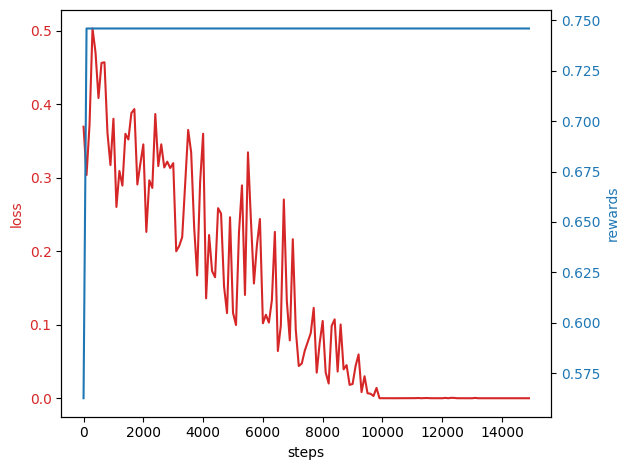

In [13]:
fig, ax1 = plt.subplots()

steps = [step for step in range(0, 15000, 100)]
color = 'tab:red'
ax1.set_xlabel('steps')
ax1.set_ylabel('loss', color=color)
ax1.plot(steps, loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('rewards', color=color)  # we already handled the x-label with ax1
ax2.plot(steps, rewards, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
plt.plot(rewards, label="Rewards")
plt.xlabel('Step')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

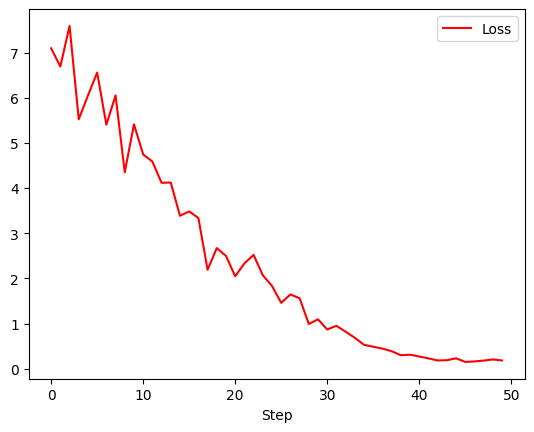

In [12]:
plt.plot(loss, label="Loss", c='r')
# plt.plot(rewards, label="Rewards")
plt.xlabel('Step')
plt.legend()
plt.show()

Save to checkpoint.

In [ ]:
# train_checkpointer.save(global_step)

# WandB

In [9]:
# Set this to True when you want to run hyperparameter tuning
hyperparameter_tuning = True

def main():
    run = wandb.init(config = config)
    
    agent_args = {
        "q_network":            get_q_net(action_spec, fc_layer_params),
        "optimizer":            tf.compat.v1.train.AdamOptimizer(
                                    learning_rate=run.config.learning_rate),
        "n_step_update":        n_step_update, 
        "td_errors_loss_fn":    tf.keras.losses.MeanSquaredError(),
        "epsilon_greedy":       run.config.epsilon_greedy,
        "target_update_period": run.config.target_update_period,
        "gamma":                run.config.gamma,
        "gradient_clipping":    1,
        "train_step_counter":   tf.compat.v1.train.get_or_create_global_step(),
    }
        
    _agent = dqn_agent.DqnAgent(
        time_step_spec,
        action_spec,
        **agent_args
    )

    loss, _, rewards = train(_agent, train_env, eval_env, steps = 5000, use_wandb = True)
    
    wandb.log({'avg_loss': np.mean(loss), 'avg_reward': np.mean(rewards)})

    del _agent
    return

# Define sweep config
sweep_configuration = {
    'method': 'random',
    'name': 'rl_greed',
    "metric": {
        "name" : "avg_reward",
        "goal": "maximize"
    },
    "parameters" : {
        "learning_rate": {
            "min": 0.0001,
            "max": 0.01
        },
        "epsilon_greedy": {'values': [0.1, 0.3, 0.5, 0.7, 0.9]},
        "target_update_period": {'values': [1, 10, 100, 1000, 10000]},
        "gamma": {'values': [0.1, 0.3, 0.5, 0.7, 0.9]},
    },
    'run_cap' : 32
}

if hyperparameter_tuning:
    ! export WANDB_NOTEBOOK_NAME="main.ipynb"
    # Initialize sweep by passing in config. (Optional) Provide a name of the project.
    sweep_id = wandb.sweep(sweep=sweep_configuration, project=PROJECT_NAME,)

    # Start sweep job.
    wandb.agent(sweep_id, function=main)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: srh8mikx
Sweep URL: https://wandb.ai/cold-machines/Reinforcement%20Learning%20%28DQN%29%20-%20JVM-GC/sweeps/srh8mikx


wandb: Agent Starting Run: 86wuplng with config:
wandb: 	epsilon_greedy: 0.7
wandb: 	gamma: 0.1
wandb: 	learning_rate: 0.009081865474555018
wandb: 	target_update_period: 100
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: valeriia-sakovskaia (cold-machines). Use `wandb login --relogin` to force relogin


  0%|          | 0/5000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
  2%|▏         | 101/5000 [00:16<18:44,  4.36it/s]

step = 100: loss = 0.051988594233989716, reward = -0.05968308076262474


  4%|▍         | 201/5000 [00:32<17:56,  4.46it/s]

step = 200: loss = 0.04959993064403534, reward = -0.05968308076262474


  6%|▌         | 301/5000 [00:48<17:17,  4.53it/s]

step = 300: loss = 0.05310416966676712, reward = -0.05968308076262474


  8%|▊         | 401/5000 [01:04<21:05,  3.64it/s]

step = 400: loss = 0.07190939784049988, reward = -0.05968308076262474


 10%|█         | 501/5000 [01:20<16:40,  4.50it/s]

step = 500: loss = 0.06140190362930298, reward = -0.05968308076262474


 12%|█▏        | 601/5000 [01:36<16:26,  4.46it/s]

step = 600: loss = 0.07814410328865051, reward = -0.05968308076262474


 14%|█▍        | 701/5000 [01:53<16:30,  4.34it/s]

step = 700: loss = 0.05395403504371643, reward = -0.05968308076262474


 16%|█▌        | 801/5000 [02:08<15:39,  4.47it/s]

step = 800: loss = 0.05778862535953522, reward = -0.05968308076262474


 18%|█▊        | 901/5000 [02:25<14:59,  4.56it/s]

step = 900: loss = 0.05692460760474205, reward = -0.05968308076262474


 20%|██        | 1001/5000 [02:41<15:17,  4.36it/s]

step = 1000: loss = 0.059485163539648056, reward = -0.05968308076262474


 22%|██▏       | 1101/5000 [02:57<14:36,  4.45it/s]

step = 1100: loss = 0.07164233177900314, reward = -0.05968308076262474


 24%|██▍       | 1201/5000 [03:14<14:20,  4.41it/s]

step = 1200: loss = 0.04963871091604233, reward = -0.05968308076262474


 26%|██▌       | 1301/5000 [03:30<14:23,  4.28it/s]

step = 1300: loss = 0.05595877766609192, reward = -0.05968308076262474


 28%|██▊       | 1401/5000 [03:46<13:25,  4.47it/s]

step = 1400: loss = 0.05879542976617813, reward = -0.05968308076262474


 30%|███       | 1501/5000 [04:02<12:52,  4.53it/s]

step = 1500: loss = 0.06716286391019821, reward = -0.05968308076262474


 32%|███▏      | 1601/5000 [04:18<13:14,  4.28it/s]

step = 1600: loss = 0.05800986662507057, reward = -0.05968308076262474


 34%|███▍      | 1701/5000 [04:35<12:29,  4.40it/s]

step = 1700: loss = 0.06368903815746307, reward = -0.05968308076262474


 36%|███▌      | 1801/5000 [04:51<12:38,  4.22it/s]

step = 1800: loss = 0.05840213596820831, reward = -0.05968308076262474


 38%|███▊      | 1901/5000 [05:07<11:47,  4.38it/s]

step = 1900: loss = 0.06790091097354889, reward = -0.05968308076262474


 40%|████      | 2001/5000 [05:24<11:03,  4.52it/s]

step = 2000: loss = 0.05456307530403137, reward = -0.05968308076262474


 42%|████▏     | 2101/5000 [05:39<10:43,  4.51it/s]

step = 2100: loss = 0.05199477821588516, reward = -0.05968308076262474


 44%|████▍     | 2201/5000 [05:56<10:51,  4.30it/s]

step = 2200: loss = 0.046316057443618774, reward = -0.05968308076262474


 46%|████▌     | 2301/5000 [06:12<09:51,  4.56it/s]

step = 2300: loss = 0.0451720654964447, reward = -0.05968308076262474


 48%|████▊     | 2401/5000 [06:28<09:59,  4.34it/s]

step = 2400: loss = 0.05063679814338684, reward = -0.05968308076262474


 50%|█████     | 2501/5000 [06:44<09:13,  4.51it/s]

step = 2500: loss = 0.05682305246591568, reward = -0.05968308076262474


 52%|█████▏    | 2601/5000 [07:01<08:57,  4.46it/s]

step = 2600: loss = 0.057316817343235016, reward = -0.05968308076262474


 54%|█████▍    | 2701/5000 [07:17<08:40,  4.42it/s]

step = 2700: loss = 0.06233186647295952, reward = -0.05968308076262474


 56%|█████▌    | 2801/5000 [07:34<08:08,  4.50it/s]

step = 2800: loss = 0.030263567343354225, reward = -0.05968308076262474


 58%|█████▊    | 2901/5000 [07:49<07:45,  4.51it/s]

step = 2900: loss = 0.12275780737400055, reward = -0.05968308076262474


 60%|██████    | 3001/5000 [08:06<07:35,  4.39it/s]

step = 3000: loss = 0.0640171468257904, reward = -0.05968308076262474


 62%|██████▏   | 3101/5000 [08:22<07:06,  4.45it/s]

step = 3100: loss = 0.06743437051773071, reward = -0.05968308076262474


 64%|██████▍   | 3201/5000 [08:39<07:00,  4.27it/s]

step = 3200: loss = 0.07279805094003677, reward = -0.05968308076262474


 66%|██████▌   | 3301/5000 [08:55<06:22,  4.45it/s]

step = 3300: loss = 0.03942070156335831, reward = -0.05968308076262474


 68%|██████▊   | 3401/5000 [09:12<06:25,  4.14it/s]

step = 3400: loss = 0.06413926929235458, reward = -0.05968308076262474


 70%|███████   | 3501/5000 [09:27<05:42,  4.38it/s]

step = 3500: loss = 0.04303019493818283, reward = -0.05968308076262474


 72%|███████▏  | 3601/5000 [09:43<05:13,  4.46it/s]

step = 3600: loss = 0.0326034352183342, reward = -0.05968308076262474


 74%|███████▍  | 3701/5000 [10:00<04:56,  4.38it/s]

step = 3700: loss = 0.06070145219564438, reward = -0.05968308076262474


 76%|███████▌  | 3801/5000 [10:16<04:34,  4.37it/s]

step = 3800: loss = 0.05568353831768036, reward = -0.05968308076262474


 78%|███████▊  | 3901/5000 [10:33<04:09,  4.40it/s]

step = 3900: loss = 0.0671439915895462, reward = -0.05968308076262474


 80%|████████  | 4001/5000 [10:49<03:42,  4.49it/s]

step = 4000: loss = 0.07973361760377884, reward = -0.05968308076262474


 82%|████████▏ | 4101/5000 [11:06<03:38,  4.11it/s]

step = 4100: loss = 0.05744113028049469, reward = -0.05968308076262474


 84%|████████▍ | 4201/5000 [11:22<03:00,  4.44it/s]

step = 4200: loss = 0.04437218979001045, reward = -0.05968308076262474


 86%|████████▌ | 4301/5000 [11:37<02:34,  4.51it/s]

step = 4300: loss = 0.06655722111463547, reward = -0.05968308076262474


 88%|████████▊ | 4401/5000 [11:55<02:13,  4.49it/s]

step = 4400: loss = 0.054657574743032455, reward = -0.05968308076262474


 90%|█████████ | 4501/5000 [12:10<01:51,  4.49it/s]

step = 4500: loss = 0.05559392273426056, reward = -0.05968308076262474


 92%|█████████▏| 4601/5000 [12:27<01:32,  4.31it/s]

step = 4600: loss = 0.062225304543972015, reward = -0.05968308076262474


 94%|█████████▎| 4678/5000 [12:39<00:49,  6.51it/s]

### Restore checkpoint

In [ ]:
def test(policy, test_env, num_episodes: int=10000):
    rewards = []
    log_interval = 100
    time_step = test_env.reset()
    total_return = 0.0
    for i in tqdm(range(10000)):
        policy_state = policy.action(time_step)
        time_step = test_env.step(policy_state.action)
        reward = time_step.reward.numpy()[0]
        total_return += reward # Calculate a sum of rewards

        if i % log_interval == 0:
            # avg_return = compute_avg_return(eval_env, agent.policy, 10)
            avg_return = total_return / eval_interval
            print('step = {0}: Average reward = {1:.5f}'.format(step, avg_return))
            rewards.append(avg_return)
            total_return = 0.0 # reset
    return rewards

# test(agent.policy, test_env)